In [1]:
#Imports 
import requests
import json
import pandas as pd
import geopandas as gpd

In [2]:
# Prepare query URL to fetch JSON data from Maryland Government site
query_url = 'https://data.montgomerycountymd.gov/api/views/mmzv-x632/rows.json?accessType=DOWNLOAD'

# Fetch data using requests
response = requests.get(query_url)

In [3]:
# Validate response status
if response.status_code == 200 :
    json_data = response.json()
else :
    print(f'URL returned response code {response.status_code}')

In [4]:
# Prepare a dictionary to create a DataFrame. Current response JSON contains 
# column names in meta attribute. Create list of dictionary with columns as keys
dictionary_list = json_data['meta']['view']['columns']
print(dictionary_list)

[{'id': -1, 'name': 'sid', 'dataTypeName': 'meta_data', 'fieldName': ':sid', 'position': 0, 'renderTypeName': 'meta_data', 'format': {}, 'flags': ['hidden']}, {'id': -1, 'name': 'id', 'dataTypeName': 'meta_data', 'fieldName': ':id', 'position': 0, 'renderTypeName': 'meta_data', 'format': {}, 'flags': ['hidden']}, {'id': -1, 'name': 'position', 'dataTypeName': 'meta_data', 'fieldName': ':position', 'position': 0, 'renderTypeName': 'meta_data', 'format': {}, 'flags': ['hidden']}, {'id': -1, 'name': 'created_at', 'dataTypeName': 'meta_data', 'fieldName': ':created_at', 'position': 0, 'renderTypeName': 'meta_data', 'format': {}, 'flags': ['hidden']}, {'id': -1, 'name': 'created_meta', 'dataTypeName': 'meta_data', 'fieldName': ':created_meta', 'position': 0, 'renderTypeName': 'meta_data', 'format': {}, 'flags': ['hidden']}, {'id': -1, 'name': 'updated_at', 'dataTypeName': 'meta_data', 'fieldName': ':updated_at', 'position': 0, 'renderTypeName': 'meta_data', 'format': {}, 'flags': ['hidden']

In [5]:
# Extract column names through list comprehension
column_names = [dictionary['name'] for dictionary in dictionary_list][8:-9]
print(column_names)

['Report Number', 'Local Case Number', 'Agency Name', 'ACRS Report Type', 'Crash Date/Time', 'Route Type', 'Road Name', 'Cross-Street Name', 'Off-Road Description', 'Municipality', 'Related Non-Motorist', 'Collision Type', 'Weather', 'Surface Condition', 'Light', 'Traffic Control', 'Driver Substance Abuse', 'Non-Motorist Substance Abuse', 'Person ID', 'Driver At Fault', 'Injury Severity', 'Circumstance', 'Driver Distracted By', 'Drivers License State', 'Vehicle ID', 'Vehicle Damage Extent', 'Vehicle First Impact Location', 'Vehicle Body Type', 'Vehicle Movement', 'Vehicle Going Dir', 'Speed Limit', 'Driverless Vehicle', 'Parked Vehicle', 'Vehicle Year', 'Vehicle Make', 'Vehicle Model', 'Latitude', 'Longitude']


In [6]:
# Extract rows from JSON and put it in a list
rows = []
for list_data in json_data['data']:
    data = list_data[8:-9]
    rows.append({column:value for column, value in zip(column_names,data)})
# Print first two records
print(json.dumps(rows[0:2], indent=4))

[
    {
        "Report Number": "DM8479000T",
        "Local Case Number": "210020119",
        "Agency Name": "Takoma Park Police Depart",
        "ACRS Report Type": "Property Damage Crash",
        "Crash Date/Time": "2021-05-27T19:40:00",
        "Route Type": null,
        "Road Name": null,
        "Cross-Street Name": null,
        "Off-Road Description": "IN PARKING LOT",
        "Municipality": null,
        "Related Non-Motorist": null,
        "Collision Type": "OTHER",
        "Weather": "CLEAR",
        "Surface Condition": null,
        "Light": "DAYLIGHT",
        "Traffic Control": "NO CONTROLS",
        "Driver Substance Abuse": "NONE DETECTED",
        "Non-Motorist Substance Abuse": null,
        "Person ID": "CF61C6EB-61C4-4627-9767-635D2F0174A6",
        "Driver At Fault": "No",
        "Injury Severity": "NO APPARENT INJURY",
        "Circumstance": "N/A",
        "Driver Distracted By": "UNKNOWN",
        "Drivers License State": "MD",
        "Vehicle ID": "D3F

In [7]:
# Create a DataFrame of crashes
df_crashes = pd.DataFrame(rows)
display(df_crashes.head())
display(df_crashes.tail())

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Name,Off-Road Description,Municipality,...,Vehicle Movement,Vehicle Going Dir,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Latitude,Longitude
0,DM8479000T,210020119,Takoma Park Police Depart,Property Damage Crash,2021-05-27T19:40:00,None,None,None,IN PARKING LOT,None,...,PARKED,None,0,No,Yes,2017,HINO,TWK,38.98765667,-76.987545
1,MCP2970000R,15045937,MONTGOMERY,Property Damage Crash,2015-09-11T13:29:00,None,None,None,Parking Lot: \n2525 Ennalls Ave,None,...,PARKING,South,5,No,No,2012,TOYOTA,SU,39.03991652,-77.05364898
2,MCP20160036,180040948,Montgomery County Police,Property Damage Crash,2018-08-17T14:25:00,None,None,None,PARKING LOT OF 16246 FREDERICK RD,None,...,BACKING,West,15,No,No,2015,MAZD,TK,38.743373,-77.54699707
3,EJ7879003C,230048975,Gaithersburg Police Depar,Injury Crash,2023-08-11T18:00:00,None,None,None,1 N SUMMIT DRIVE,None,...,MOVING CONSTANT SPEED,Unknown,15,No,No,2018,RAM,TK,39.14587303,-77.19194047
4,MCP2967004Y,230070277,Montgomery County Police,Property Damage Crash,2023-12-06T18:42:00,Maryland (State),CONNECTICUT AVE,BALTIMORE ST,None,KENSINGTON,...,MOVING CONSTANT SPEED,South,35,No,No,2017,AUDI,A3,39.02517017,-77.07633333


,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Name,Off-Road Description,Municipality,...,Vehicle Movement,Vehicle Going Dir,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Latitude,Longitude
185738,MCP3362004B,240046185,MONTGOMERY,Property Damage Crash,2024-09-26T15:10:00,Maryland (State) Route,UNIVERSITY BLVD E,None,None,None,...,Moving Constant Speed,Eastbound,35,No,No,2024,SUBARU,FORESTER,39.01918006,-77.01205996
185739,MCP2513004H,240046173,MONTGOMERY,Injury Crash,2024-09-27T13:39:00,Maryland (State) Route,GEORGIA AVE (SB/L),None,None,None,...,Slowing or Stopping,Northbound,30,No,No,2022,KIA,SOUL,39.00891438,-77.04029211
185740,MCP2209002W,240046274,MONTGOMERY,Injury Crash,2024-09-27T22:09:00,County Route,None,None,None,None,...,Moving Constant Speed,Northbound,35,No,No,2017,GMC,SIERRA,38.99480394,-77.19099956
185741,MCP3230005Z,240045796,MONTGOMERY,Property Damage Crash,2024-09-25T15:48:00,None,None,None,Parking Aisle 12218 VEIRS MILL RD ROCKV...,None,...,Slowing or Stopping,Not On Roadway,0,No,No,2013,FORD,ESCAPE,39.05649515,-77.08386851
185742,MCP2586007P,240042493,MONTGOMERY,Property Damage Crash,2024-09-07T17:34:00,Maryland (State) Route,WOODFIELD RD,None,None,None,...,Moving Constant Speed,Southbound,35,No,No,2003,TOYOTA,TUNDRA,39.27783755,-77.20412452


In [8]:
# Display columns
df_crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185743 entries, 0 to 185742
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   Report Number                  185743 non-null  object
 1   Local Case Number              185743 non-null  object
 2   Agency Name                    185743 non-null  object
 3   ACRS Report Type               185743 non-null  object
 4   Crash Date/Time                185743 non-null  object
 5   Route Type                     167555 non-null  object
 6   Road Name                      166885 non-null  object
 7   Cross-Street Name              161349 non-null  object
 8   Off-Road Description           17151 non-null   object
 9   Municipality                   156182 non-null  object
 10  Related Non-Motorist           5936 non-null    object
 11  Collision Type                 185743 non-null  object
 12  Weather                        185743 non-nu

In [9]:
# Create a focused DataFrame with limited columns
required_columns = ['Report Number','Crash Date/Time','Weather',
                    'Surface Condition','Injury Severity','Vehicle ID',
                    'Vehicle Year', 'Vehicle Make', 'Vehicle Model', 'Latitude', 'Longitude', 'ACRS Report Type']

# Create focused DataFrame
df_focused_crashes = df_crashes[required_columns].copy()

display(df_focused_crashes.head())
display(df_focused_crashes.tail())

,Report Number,Crash Date/Time,Weather,Surface Condition,Injury Severity,Vehicle ID,Vehicle Year,Vehicle Make,Vehicle Model,Latitude,Longitude,ACRS Report Type
0,DM8479000T,2021-05-27T19:40:00,CLEAR,None,NO APPARENT INJURY,D3F480EE-638B-459A-BC20-533741BC4F76,2017,HINO,TWK,38.98765667,-76.987545,Property Damage Crash
1,MCP2970000R,2015-09-11T13:29:00,CLEAR,None,NO APPARENT INJURY,14ECEFCD-3A58-4991-A9C6-A9D5CA54B419,2012,TOYOTA,SU,39.03991652,-77.05364898,Property Damage Crash
2,MCP20160036,2018-08-17T14:25:00,CLEAR,None,NO APPARENT INJURY,995C9706-91EC-48FC-8D2A-31759590E3EA,2015,MAZD,TK,38.743373,-77.54699707,Property Damage Crash
3,EJ7879003C,2023-08-11T18:00:00,CLEAR,None,NO APPARENT INJURY,EDF71D99-8A86-4CCD-BD22-3F32076A134A,2018,RAM,TK,39.14587303,-77.19194047,Injury Crash
4,MCP2967004Y,2023-12-06T18:42:00,CLEAR,DRY,NO APPARENT INJURY,9870F867-5BC8-4ABB-BA69-A2E515C416CD,2017,AUDI,A3,39.02517017,-77.07633333,Property Damage Crash


,Report Number,Crash Date/Time,Weather,Surface Condition,Injury Severity,Vehicle ID,Vehicle Year,Vehicle Make,Vehicle Model,Latitude,Longitude,ACRS Report Type
185738,MCP3362004B,2024-09-26T15:10:00,Clear,Dry,No Apparent Injury,2EE068B5-6F25-4625-B3E8-61217607F83A,2024,SUBARU,FORESTER,39.01918006,-77.01205996,Property Damage Crash
185739,MCP2513004H,2024-09-27T13:39:00,Rain,Wet,No Apparent Injury,B9472D7D-24F5-46E8-A401-F6EF67E1E67D,2022,KIA,SOUL,39.00891438,-77.04029211,Injury Crash
185740,MCP2209002W,2024-09-27T22:09:00,Rain,Wet,No Apparent Injury,F646F202-371B-484D-9E90-642D6679E6AA,2017,GMC,SIERRA,38.99480394,-77.19099956,Injury Crash
185741,MCP3230005Z,2024-09-25T15:48:00,Rain,None,No Apparent Injury,51E75CE3-7BA7-471B-833D-93E475C9FA53,2013,FORD,ESCAPE,39.05649515,-77.08386851,Property Damage Crash
185742,MCP2586007P,2024-09-07T17:34:00,Clear,Dry,None,4932A655-01F4-4A3D-A8A2-1E8CFE7AE43E,2003,TOYOTA,TUNDRA,39.27783755,-77.20412452,Property Damage Crash


In [10]:
# Convert Crash Date/Time to proper datetime datatype
df_focused_crashes['Crash Date/Time'] = pd.to_datetime(df_focused_crashes['Crash Date/Time'])

In [11]:
# Data clean up and sorting
df_focused_crashes.drop_duplicates(subset='Report Number', inplace=True)
df_focused_crashes.sort_values(by='Crash Date/Time', inplace=True)
df_focused_crashes.head()

,Report Number,Crash Date/Time,Weather,Surface Condition,Injury Severity,Vehicle ID,Vehicle Year,Vehicle Make,Vehicle Model,Latitude,Longitude,ACRS Report Type
66126,MCP11520005,2015-01-01 00:30:00,CLEAR,DRY,NO APPARENT INJURY,EED35F71-B94E-4225-98D4-3405AEA57D0B,1993,BUICK,4S,39.02200107,-77.10267305,Property Damage Crash
44614,MCP2686000D,2015-01-01 01:10:00,N/A,DRY,NO APPARENT INJURY,3F9C76B4-F704-4FA7-87AB-B3BAEBBC5146,2007,JEEP,COMPASS,39.19661,-77.26554667,Property Damage Crash
14306,MCP2783000G,2015-01-01 01:14:00,CLEAR,DRY,NO APPARENT INJURY,89F9B6F8-1F89-4EBD-84A3-D0DAE2D7A90C,1999,FORD,PICK UP,39.09621667,-77.10980333,Injury Crash
79817,MCP2674000D,2015-01-01 01:26:00,CLEAR,DRY,NO APPARENT INJURY,D6C5600D-D372-44B3-96AF-B1F24A05F5AF,1998,ISU,RODEO,39.158059,-77.204349,Property Damage Crash
141094,MCP23000002,2015-01-01 02:00:00,CLEAR,DRY,NO APPARENT INJURY,D08E5FC7-8FA0-454B-A3EF-27002B08324B,2009,FORD,CROWN VIC,39.148678,-77.093848,Property Damage Crash


In [12]:
# More data cleanup with values to merge duplicate variations and fill blanks 
# with 'NO APPARENT INJURY' for better visualization
df_focused_crashes['Injury Severity'] = df_focused_crashes['Injury Severity'].str.upper()
rename_values = {'POSSIBLE INJURY' : 'SUSPECTED MINOR INJURY'}
df_focused_crashes['Injury Severity'] = df_focused_crashes['Injury Severity'].replace(rename_values)
df_focused_crashes['Injury Severity'] = df_focused_crashes['Injury Severity']
df_focused_crashes['Injury Severity'] = df_focused_crashes['Injury Severity'].fillna('NO APPARENT INJURY')
df_focused_crashes['Injury Severity'].value_counts(dropna=False)

Injury Severity
NO APPARENT INJURY          86682
SUSPECTED MINOR INJURY      16849
SUSPECTED SERIOUS INJURY      941
FATAL INJURY                  129
Name: count, dtype: int64

In [13]:
# Clean up for weather values to have better visualization
weather_mapping = {
    'RAINING': 'RAIN',
    'N/A': 'OTHER',
    'SLEET': 'WINTRY MIX',
    'BLOWING SNOW': 'SNOW',
    'FOG, SMOG, SMOKE': 'FOGGY',
    'FREEZING RAIN OR FREEZING DRIZZLE': 'WINTRY MIX',
    'SEVERE WINDS': 'WINDY',
    'SEVERE CROSSWINDS': 'WINDY',
    'SLEET OR HAIL': 'WINTRY MIX',
    'UNKNOWN': 'OTHER',
    'BLOWING SAND, SOIL, DIRT': 'OTHER'
}
# Fix for the descripancies in the text casing
df_focused_crashes['Weather'] = df_focused_crashes['Weather'].str.upper()

# Merge scattered values to relevant values
df_focused_crashes['Weather'] = df_focused_crashes['Weather'].replace(weather_mapping)

df_focused_crashes['Weather'].value_counts()

Weather
CLEAR         71053
RAIN          12574
CLOUDY        10290
OTHER          8727
SNOW           1034
FOGGY           439
WINTRY MIX      388
WINDY            96
Name: count, dtype: int64

In [14]:
# Clean up for surface condition
surface_condition_mapping = {
    'N/A':'OTHER',
    'UNKNOWN':'OTHER',
    'SLUSH':'WINTRY MIX',
    'ICE/FROST':'ICE',
    'MUD, DIRT, GRAVEL':'OTHER',
    'WATER(STANDING/MOVING)':'FLOOD',
    'OIL':'OTHER',
    'WATER (STANDING, MOVING)':'FLOOD',
    'SAND': 'OTHER'
}

# Fix for the descripancies in the text casing
df_focused_crashes['Surface Condition'] = df_focused_crashes['Surface Condition'].str.upper()

# Merge scattered values to relevant values
df_focused_crashes['Surface Condition'] = df_focused_crashes['Surface Condition'].replace(surface_condition_mapping)

#df_focused_crashes['Surface Condition'].value_counts()

# Clean up for seemingly unrealistic years
df_focused_crashes['Vehicle Year'] = pd.to_numeric(df_focused_crashes['Vehicle Year'])
df_focused_crashes = df_focused_crashes.loc[(df_focused_crashes['Vehicle Year'] >= 1930) & (df_focused_crashes['Vehicle Year'] <= 2025)]
#df_focused_crashes.info()

df_focused_crashes['Surface Condition'].value_counts()

Surface Condition
DRY           68449
WET           16649
OTHER          2707
ICE             715
SNOW            633
WINTRY MIX      144
FLOOD            34
Name: count, dtype: int64

<Axes: >

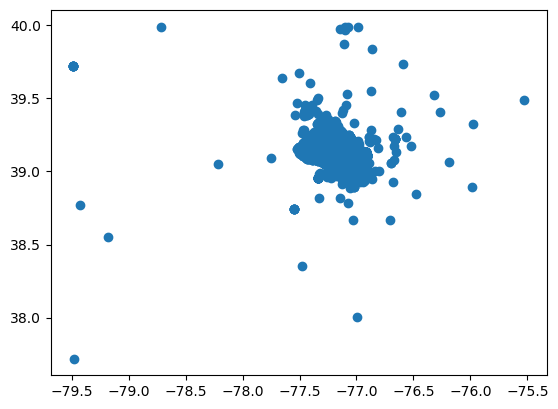

In [15]:
# Check if all of the latitudes and longitudes are within Montgomery county of Maryland
montgomery_gdf = gpd.GeoDataFrame(df_focused_crashes, geometry=gpd.points_from_xy(df_focused_crashes.Longitude, df_focused_crashes.Latitude))
montgomery_gdf.crs = 'EPSG:4326'
montgomery_gdf.plot()

<Axes: >

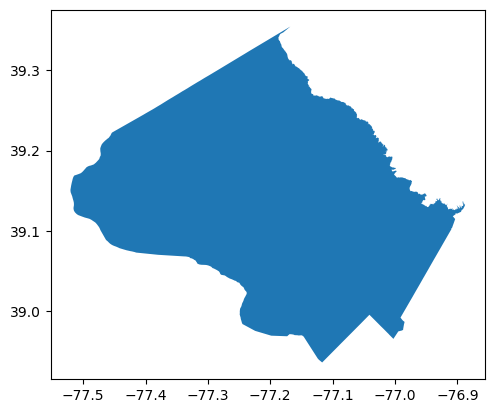

In [16]:
# Load county map with boundaries and plot it
county_gdf = gpd.read_file('../Resources/Montgomery_County.json')
county_gdf.plot()

<Axes: >

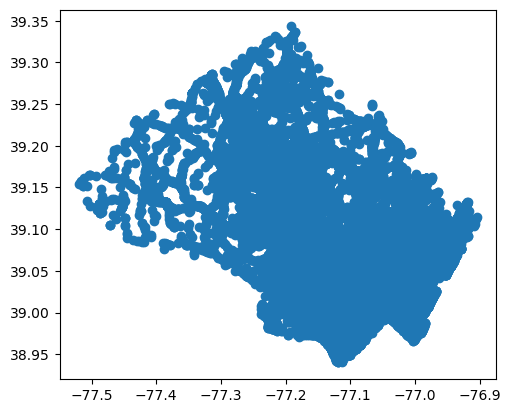

In [17]:
# Filter out all of the accidents occured outside of county and filter data further
# and plot data to verify
data_crash_clip = gpd.clip(montgomery_gdf, county_gdf)
data_crash_clip.plot()

In [18]:
# Final look at the columns before export to a CSV file
data_crash_clip.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 101138 entries, 58837 to 132668
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Report Number      101138 non-null  object        
 1   Crash Date/Time    101138 non-null  datetime64[ns]
 2   Weather            101138 non-null  object        
 3   Surface Condition  89062 non-null   object        
 4   Injury Severity    101138 non-null  object        
 5   Vehicle ID         101138 non-null  object        
 6   Vehicle Year       101138 non-null  int64         
 7   Vehicle Make       101138 non-null  object        
 8   Vehicle Model      101137 non-null  object        
 9   Latitude           101138 non-null  object        
 10  Longitude          101138 non-null  object        
 11  ACRS Report Type   101138 non-null  object        
 12  geometry           101138 non-null  geometry      
dtypes: datetime64[ns](1), geometry(1), in

In [19]:
# Export to the CSV
data_crash_clip.to_csv('../Resources/Montgomery_Crash_Data.csv', index=False)